In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import rasterio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.feature_extraction.image import extract_patches_2d

import cProfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def cum_sum(arr, s):
    cumsum = torch.cumsum(torch.cumsum(arr,dim=2),dim=3)
    cumsum = F.pad(cumsum,(1,0,1,0),'constant',0)
    tot = cumsum[:,:,:-s,:-s]-cumsum[:,:,s:,:-s]-cumsum[:,:,:-s,s:]+cumsum[:,:,s:,s:]
    return tot

def to_disp(arr):
    arr_c = arr.cpu().numpy()
    arr_c = np.rollaxis(np.squeeze(arr_c),0,3)
    return arr_c

#learns N x N epitome from T, K x K random patches drawn from input image x.
#Applies NIT iterations of the E-M algorithm at scale sc; T*sc^2 patches are sampled.
#e,ev = initial epitome mean and variance. The mean is initialized
#to the uniform image with some small noise, and the variance is initialized to 1
#p holds an array of probabilities of using each part of the epitome

def epitome(x,K,N,T,NIT,sc):
    xFIN = x
    x = torch.clamp(F.interpolate(x,scale_factor=sc[0]),min=0,max=1)
    _, numDim, SY, SX = x.shape
    TFIN = T
    T = int(np.ceil(T*sc[0]**2))
    NFIN = N
    N = int(np.ceil(sc[0]*N))
    #e = mean of image plus noise
    e = torch.zeros((1,numDim,N,N)).to(device)
    ev = torch.ones((1,numDim,N,N)).to(device)/50
    for i in range(numDim):
        e[:,i,:,:] = x[0,i,:,:].std()*torch.randn(N,N).to(device)/100+x[0,i,:,:].mean()
    p = torch.ones((N,N)).to(device)/N**2
    MINP = 1e-8#1e-8 is acceptable
    MINV = 1e-2#1e-6
    #allocate trace of epitome
    etr = torch.zeros((NIT+1,1,numDim,NFIN,NFIN))
    etr[0,:,:,:,:] = F.interpolate(e,[NFIN,NFIN])
    #perform NIT iterations of EM algorithm
    for sci in range(len(sc)):
        if sci != 0:
            N = int(np.ceil(sc[sci]*NFIN))
            e = torch.clamp(F.interpolate(e,[N,N]),min=0,max=1).to(device)
            ev = torch.clamp(F.interpolate(ev,[N,N]),min=MINV).to(device)
            p = torch.ones((N,N)).to(device)/N**2
            x = torch.clamp(F.interpolate(xFIN,scale_factor=sc[sci]),min=0,max=1).to(device)
            T = int(np.ceil(sc[sci]**2*TFIN))
        sumP = torch.zeros((N,N),dtype=torch.float).to(device)
        sumPy = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        sumPy2 = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        ewrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        evwrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        SY = x.shape[2]
        SX = x.shape[3]
        patchnum = min(T,(SY-K)**2)
        #print(patchnum)
        ytemp = np.rollaxis(extract_patches_2d(torch.squeeze(x).permute(1,2,0),(K,K),max_patches=patchnum),3,1)
        y = torch.from_numpy(ytemp).float().to(device)
        for nit in range(NIT):
            #glues together borders of e
            ewrap[:,:N,:N] = e;
            ewrap[:,N:,:] = ewrap[:,:K-1,:]
            ewrap[:,:,N:] = ewrap[:,:,:K-1]
            evwrap[:,:N,:N] = ev
            evwrap[:,N:,:] = evwrap[:,:K-1,:]
            evwrap[:,:,N:] = evwrap[:,:,:K-1]
            evwrapi = 1./evwrap
            # E STEP
            sumP[:,:] = 0
            sumPy[:,:,:] = 0
            sumPy2[:,:,:] = 0
            yt = torch.flip(y,[2,3])
            tmp1full = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),yt**2))
            tmp2full = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrapi,0),yt))
            tmp3 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2*evwrapi,0),K)),dim=0)
            tmp4 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(torch.log(evwrap),0),K)),dim=0)
            for t in range(patchnum):
                yc = y[t,:,:,:]
                #compute posterior over patch location
                #lP = torch.log(p).to(device)
                tmp1 = tmp1full[t,:,:]
                tmp2 = tmp2full[t,:,:]
                #tmp1 = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),yct**2))
                #tmp2 = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrapi,0),yct))
                lP = torch.log(p)-.5*(tmp4+tmp1-2*tmp2+tmp3)
                #lP -= .5*(tmp4+tmp1-2*tmp2+tmp3)
                P = torch.exp(lP-torch.max(lP))+MINP
                P /= torch.sum(P)
                #update mean and variance
                tmp = F.pad(P.view(1,1,N,N),(K-1,K-1,K-1,K-1),'constant',0).to(device)
                tmp_sumP = torch.squeeze(cum_sum(tmp,K))
                tmp_sumP[:,:K-1] += tmp_sumP[:,N:]
                tmp_sumP[:K-1,:] += tmp_sumP[N:,:]
                sumP += tmp_sumP[:N,:N]
                yctmp = torch.unsqueeze(yc,1)
                tmp_sumPy = torch.squeeze(F.conv2d(tmp,yctmp))
                tmp_sumPy[:,:,:K-1] += tmp_sumPy[:,:,N:]
                tmp_sumPy[:,:K-1,:] += tmp_sumPy[:,N:,:]
                sumPy += tmp_sumPy[:,:N,:N]
                tmp_sumPy2 = torch.squeeze(F.conv2d(tmp,yctmp**2))
                tmp_sumPy2[:,:,:K-1] += tmp_sumPy2[:,:,N:]
                tmp_sumPy2[:,:K-1,:] += tmp_sumPy2[:,N:,:]
                sumPy2 += tmp_sumPy2[:,:N,:N]
            del tmp1full, tmp2full,tmp,tmp_sumPy,tmp_sumPy2
            torch.cuda.empty_cache()
            #M STEP
            #p = sumP/torch.sum(sumP)#commented out
            e[0,:,:,:] = sumPy/sumP
            if nit>10 or sci>0:
                ev[0,:,:,:] = sumPy2/sumP - 2*e[0,:,:,:]*sumPy/sumP+e[0,:,:,:]**2
            ev = torch.clamp(ev,min=MINV)
            etemp = F.interpolate(e,[NFIN,NFIN])
            etr[nit+1,:,:,:] = etemp
            fig=plt.figure(figsize=(15,5))
            fig.add_subplot(131)
            plt.axis('off')
            td = to_disp(etemp[:,:3,:,:])
            plt.imshow(td)
            plt.title(str(N)+'x'+str(N)+' epitome')
            fig.add_subplot(132)
            plt.axis('off')
            #plt.imshow(p,cmap='hot',interpolation='nearest')
            plt.title('mixing proportions')
            fig.add_subplot(133)
            plt.axis('off')
            curr_heat = np.sum(np.squeeze(ev.cpu().numpy()),axis=0)
            plt.imshow(curr_heat,cmap='hot',interpolation='nearest')
            plt.title('variances, max=%.3f' % (max(curr_heat.flatten())))
            plt.show()
            plt.close()   
        torch.cuda.empty_cache()
    return e,ev,p,etr

[2 3 4 5 6]


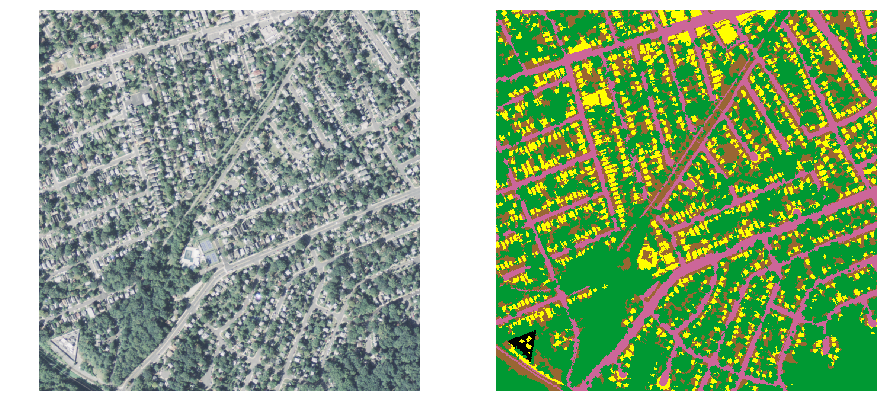

CPU times: user 2.83 s, sys: 723 ms, total: 3.55 s
Wall time: 4.96 s


In [7]:
%%time
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])

tile = 0
cut = 1024
naip_tile = rasterio.open("/mnt/blobfuse/esri-naip/"+paths[tile][:-7]+".mrf",'r')
naip = naip_tile.read().astype(float)[:,:cut,:cut]/255.
naip_tile.close()

lc_tile = rasterio.open('/mnt/blobfuse/resampled-lc/'+paths[tile],'r')
lc = np.squeeze(lc_tile.read())[:cut,:cut]
lc_tile.close()
print(np.unique(lc))
lc[lc==1]=10
lc[lc==2]=1
lc[lc==10]=2
lc[lc==4]=0
lc[lc==15]=4
fig=plt.figure(figsize=(15,10))
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(np.rollaxis(naip,0,3)[:,:,:3])
fig.add_subplot(1,2,2)
plt.axis('off')
plt.imshow(palette[lc])
plt.show()
plt.close()

trIM = np.zeros((10,naip.shape[1],naip.shape[2]),dtype=float)
trIM[:4,:,:] = naip
for i in range(6):
    trIM[4+i,:,:] = (lc==(i+1))
trIM = np.expand_dims(trIM,axis=0)
trIMtorch = torch.from_numpy(trIM).float().to(device)
tsIMtorch = trIMtorch

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


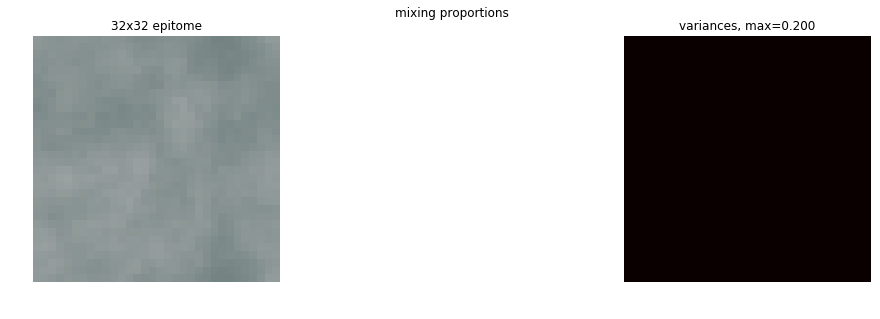

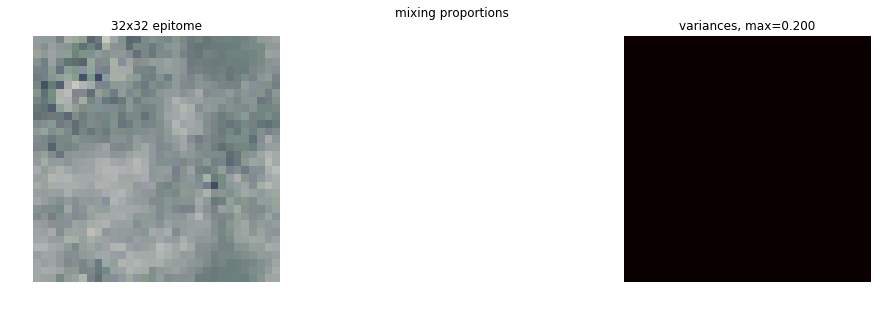

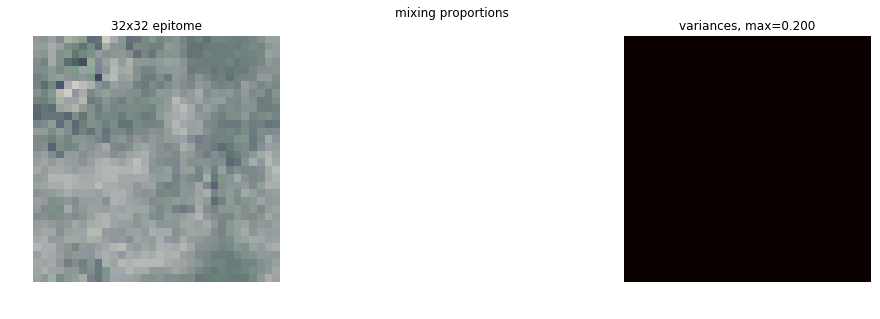

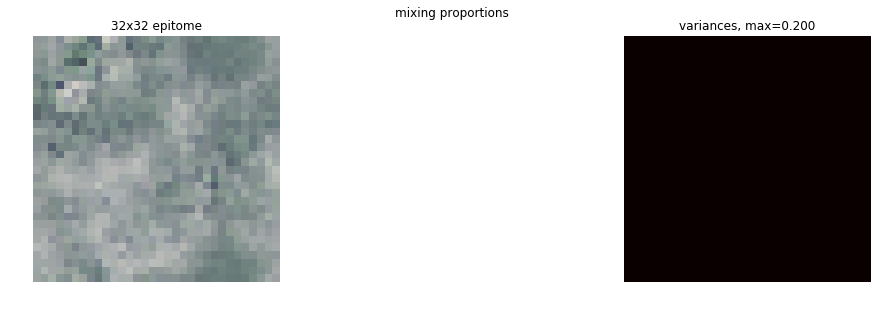

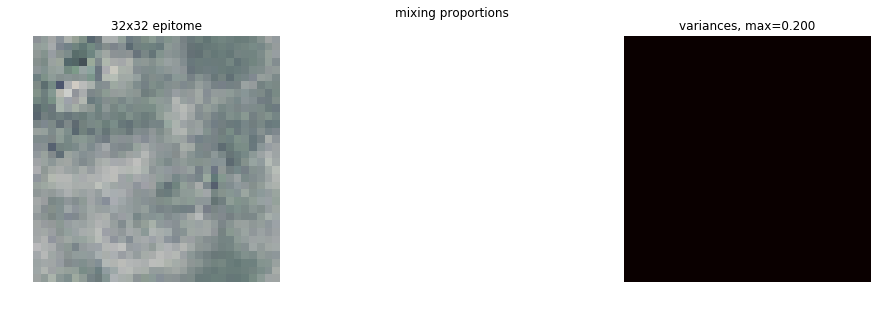

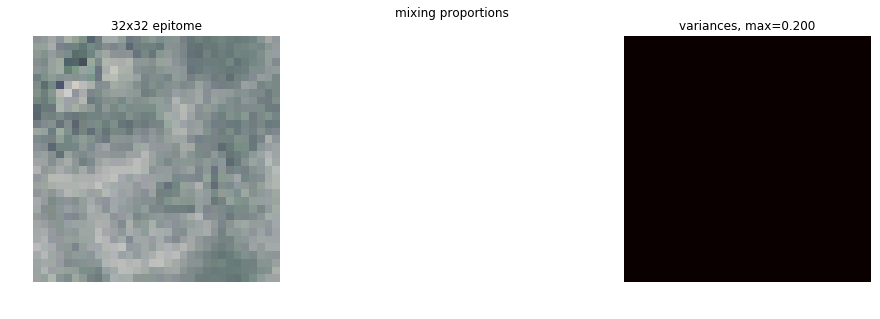

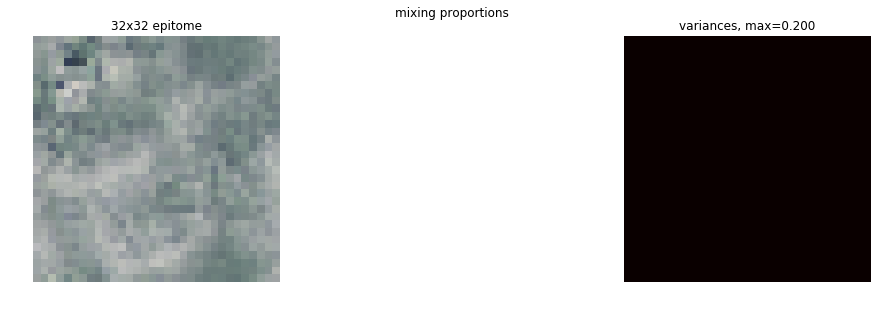

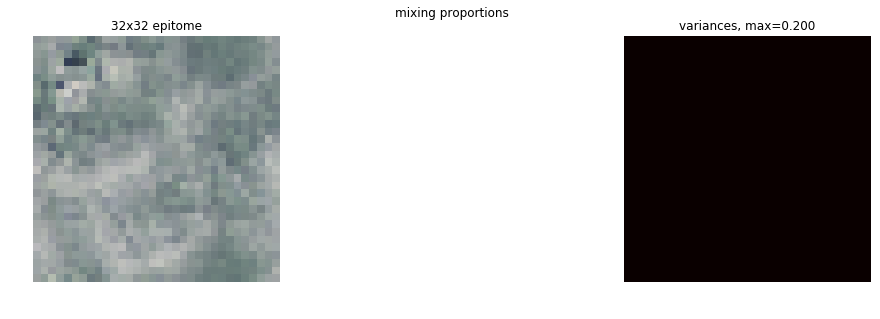

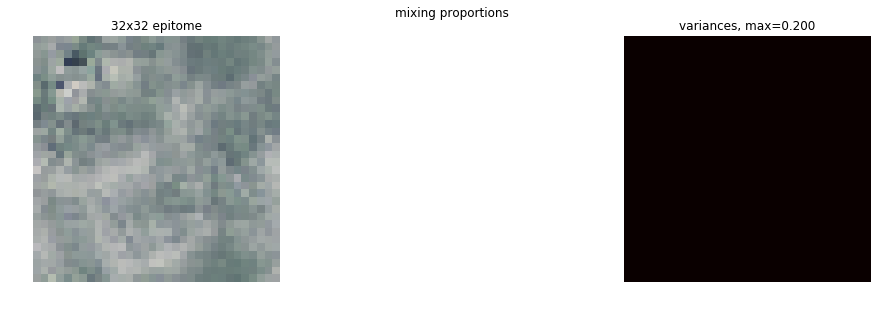

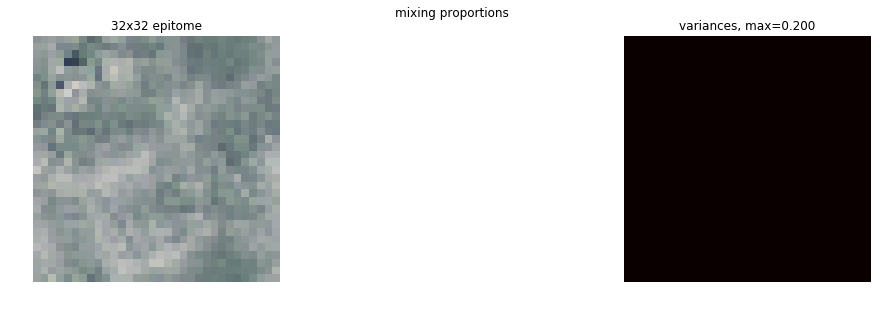

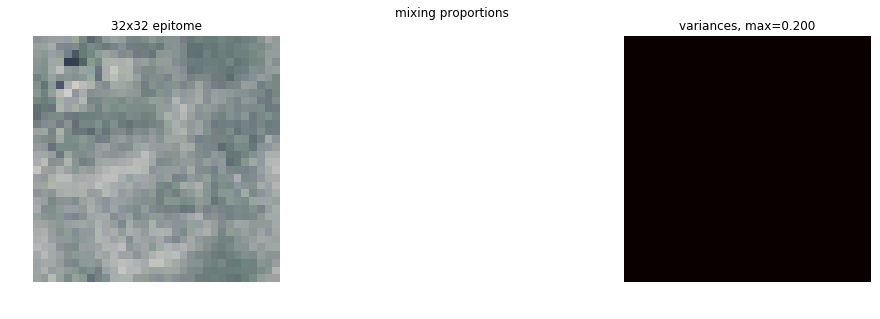

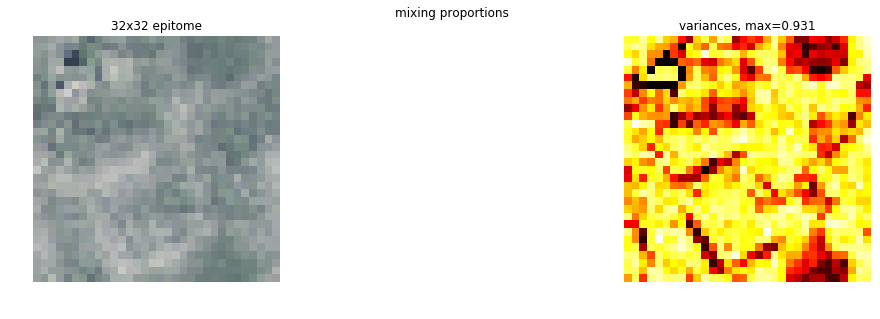

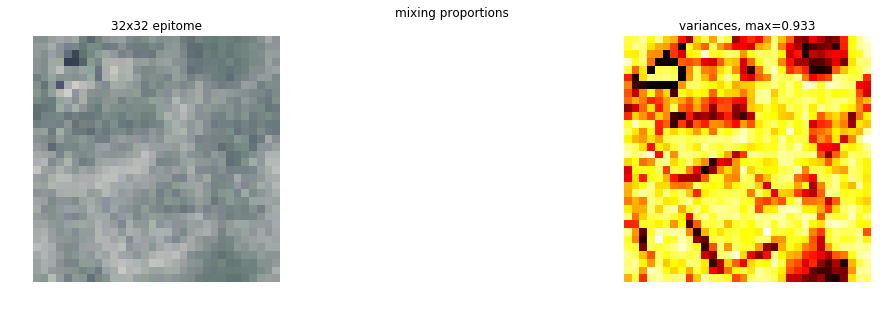

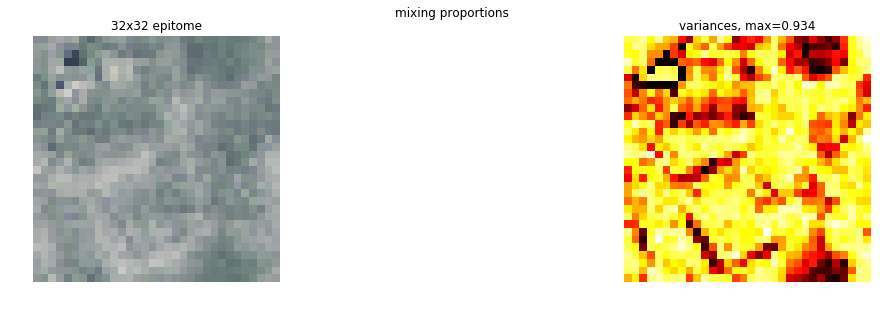

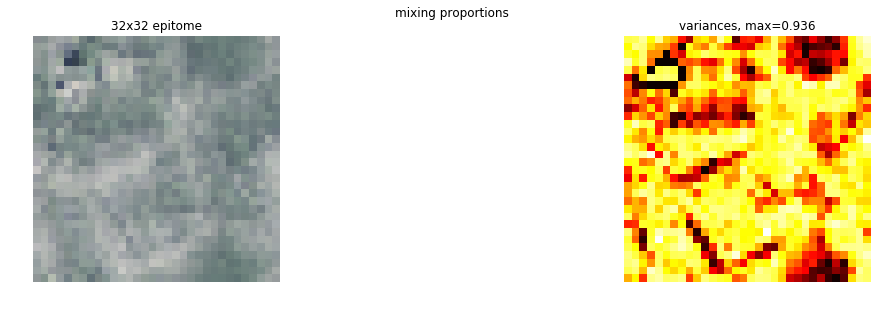

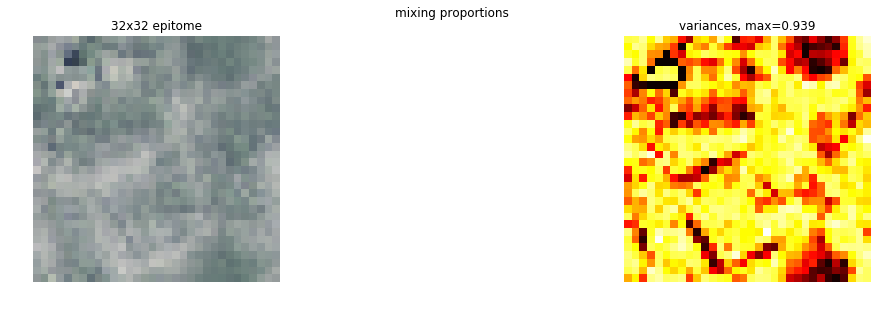

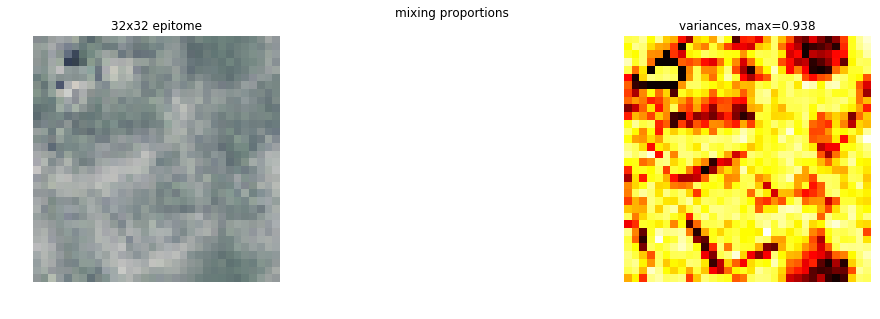

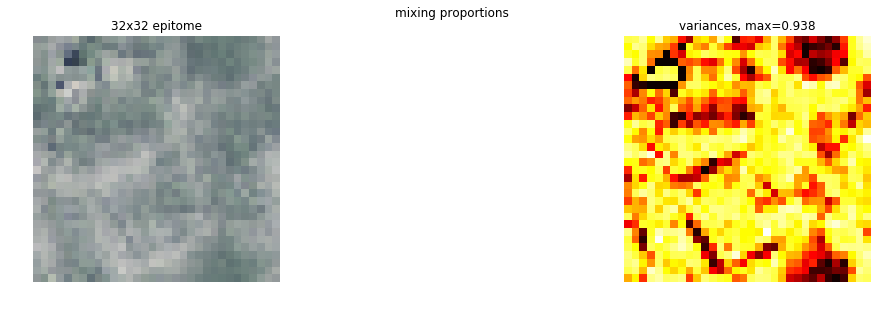

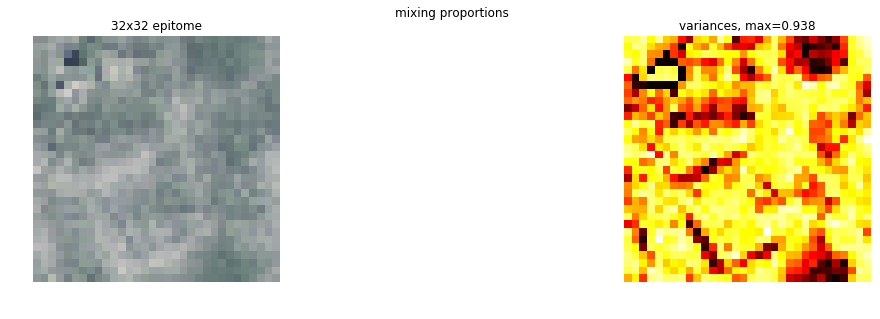

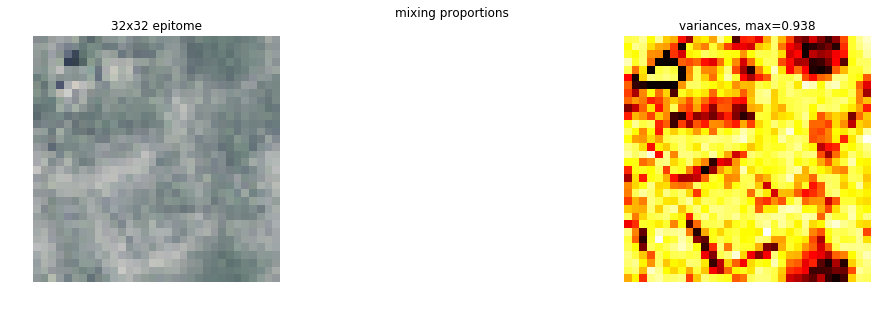

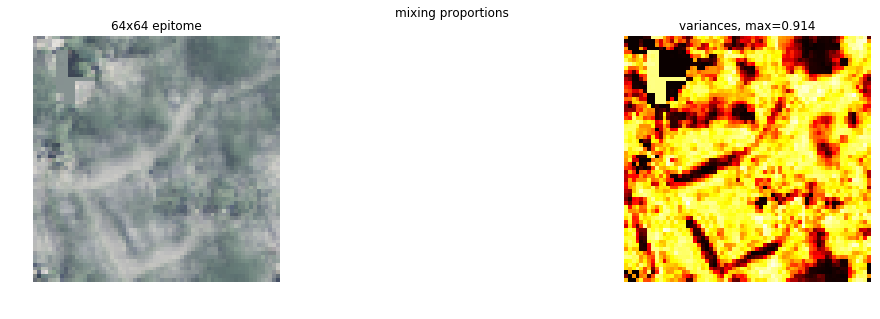

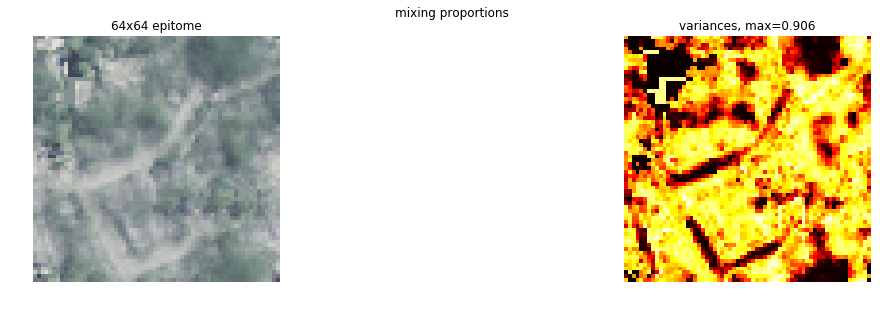

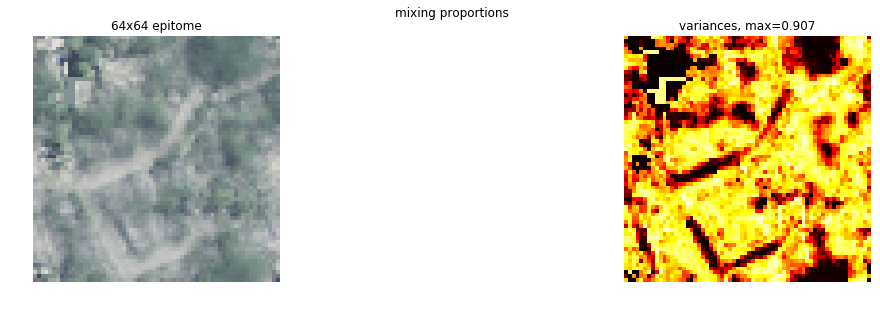

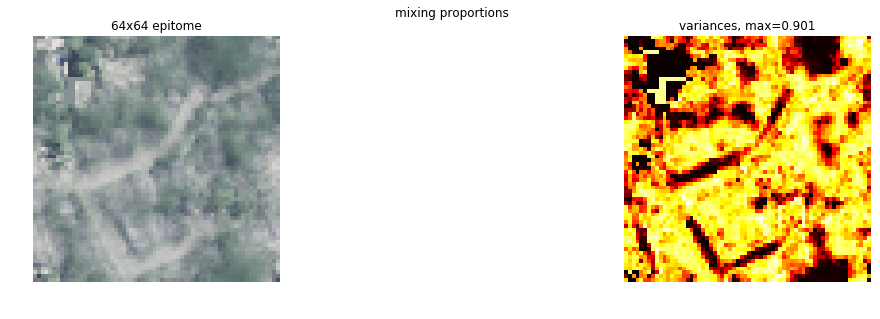

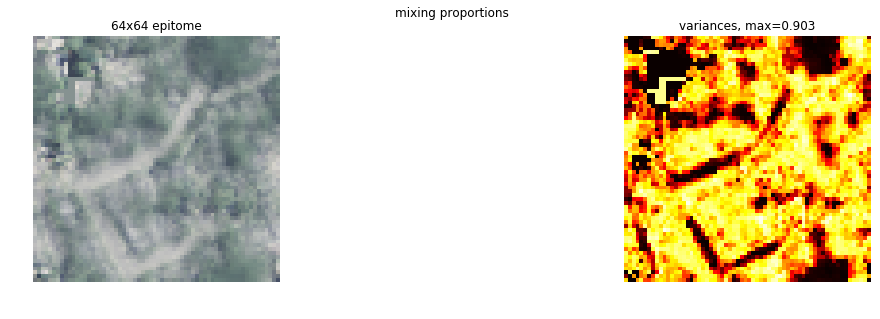

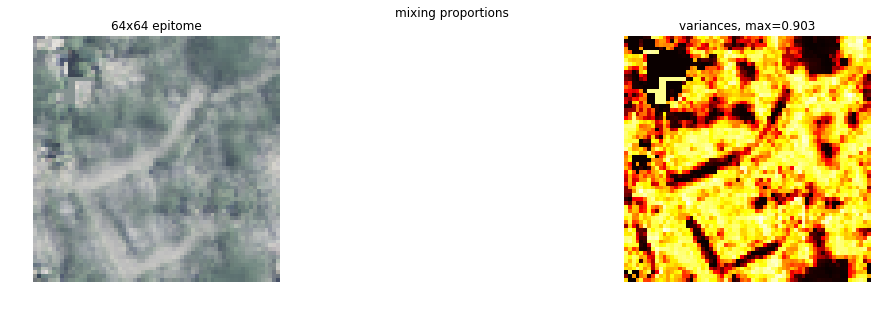

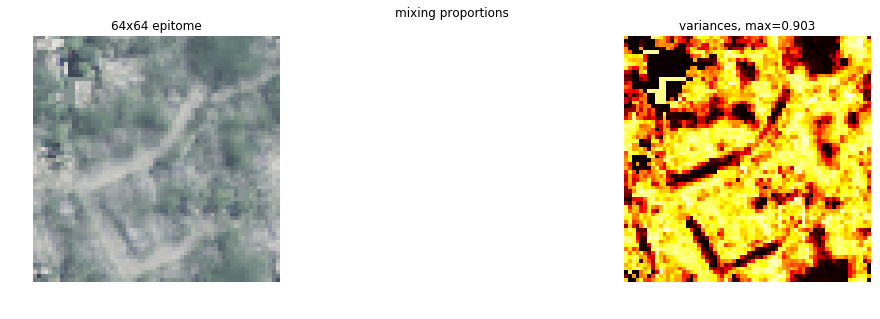

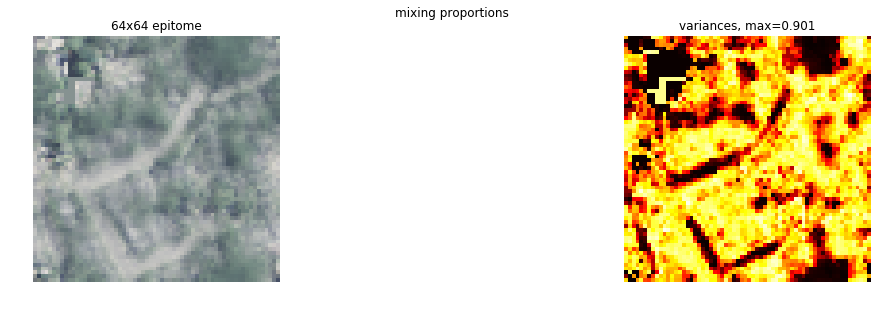

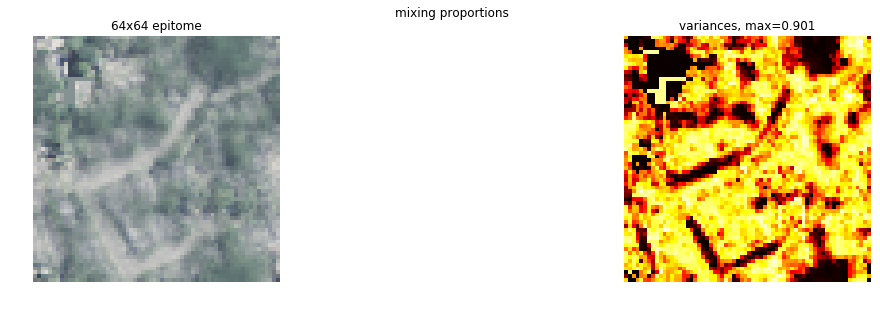

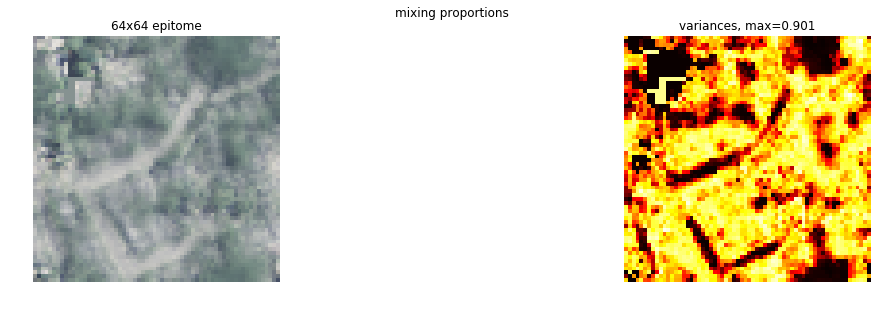

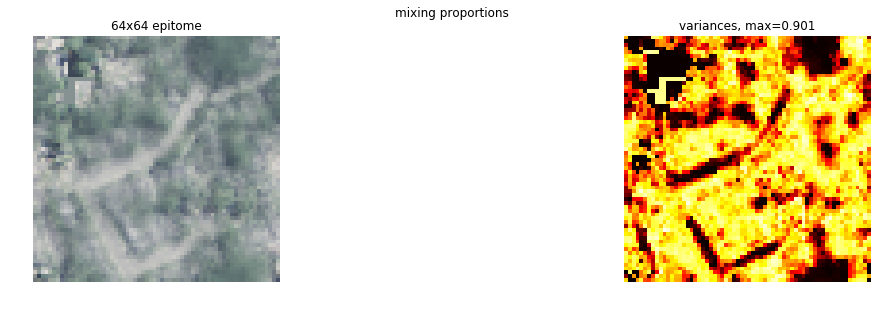

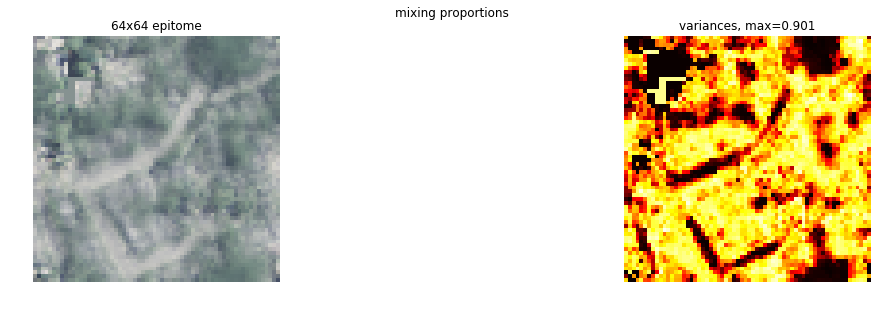

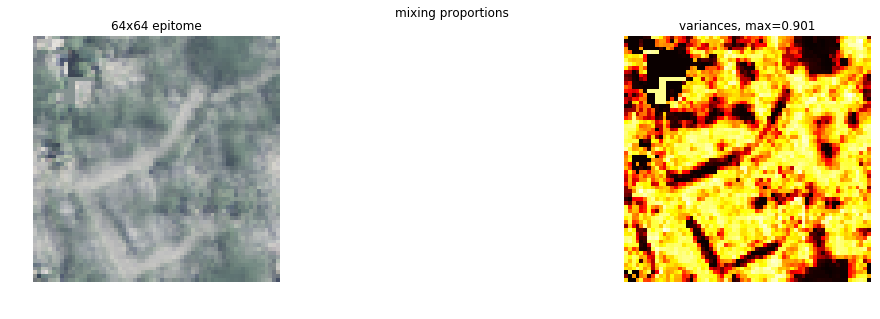

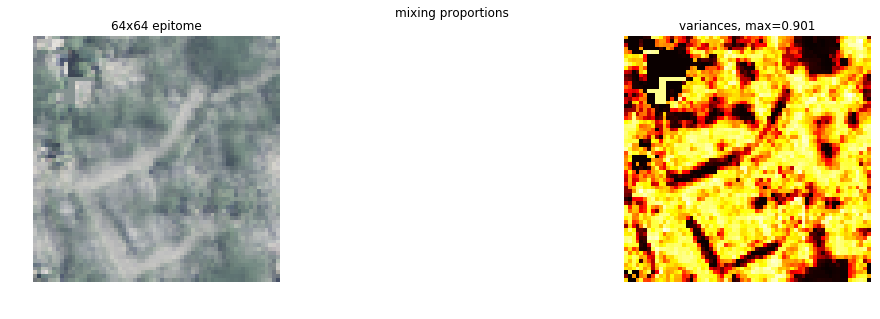

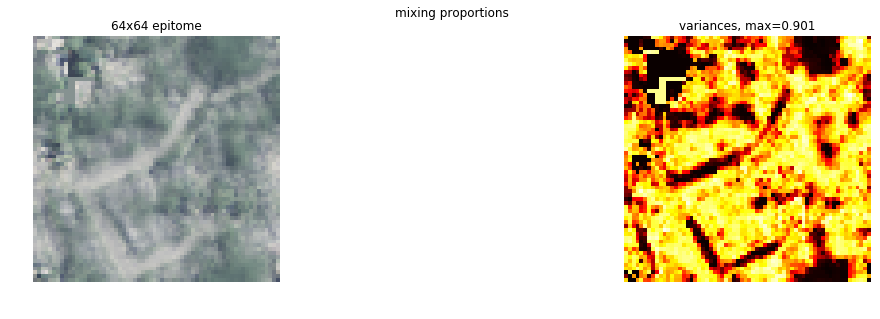

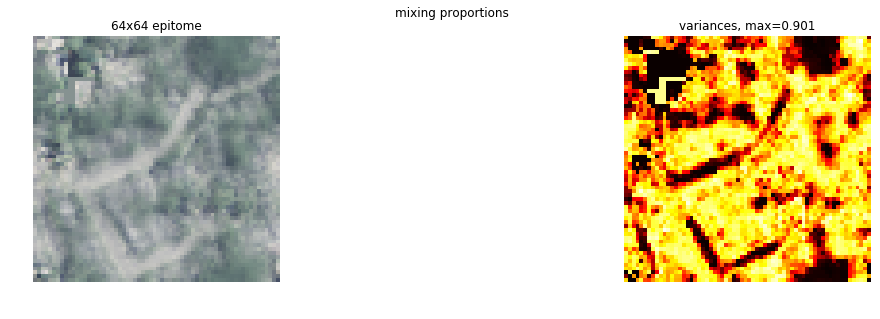

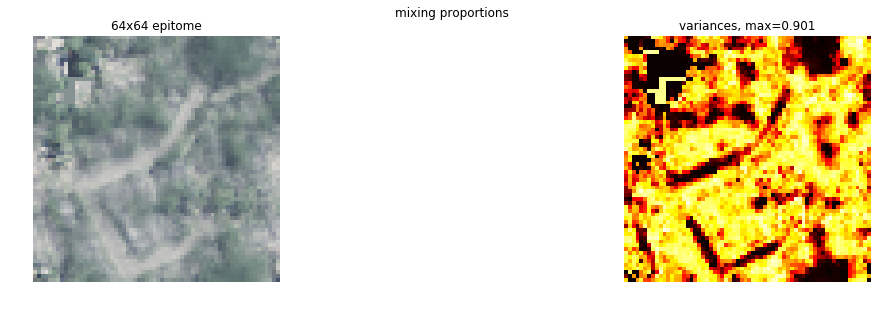

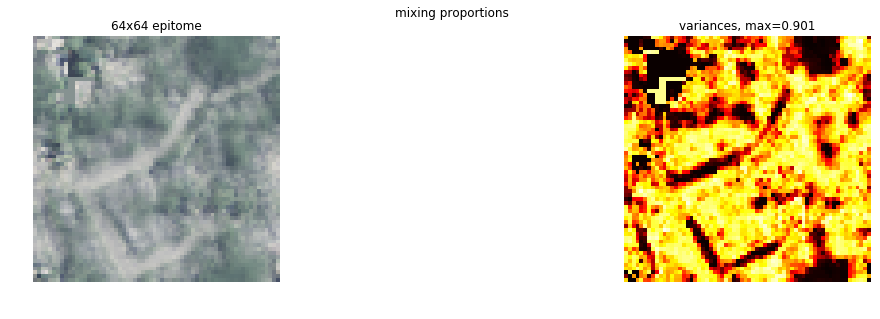

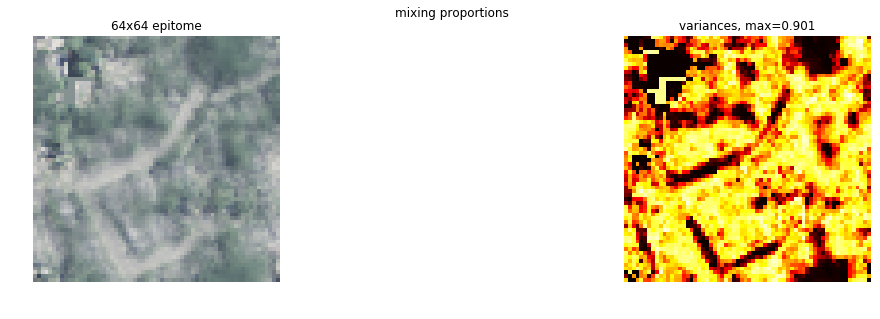

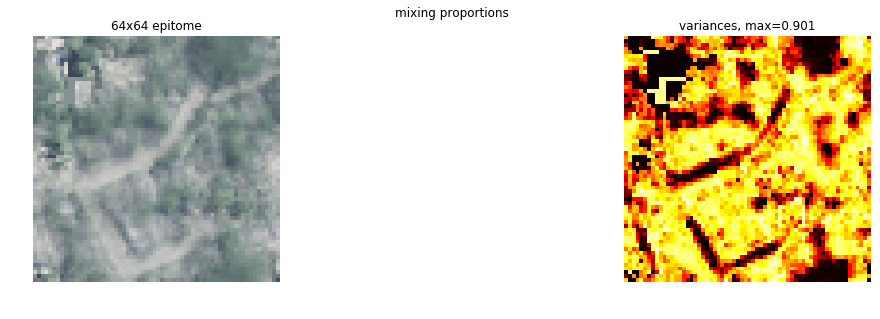

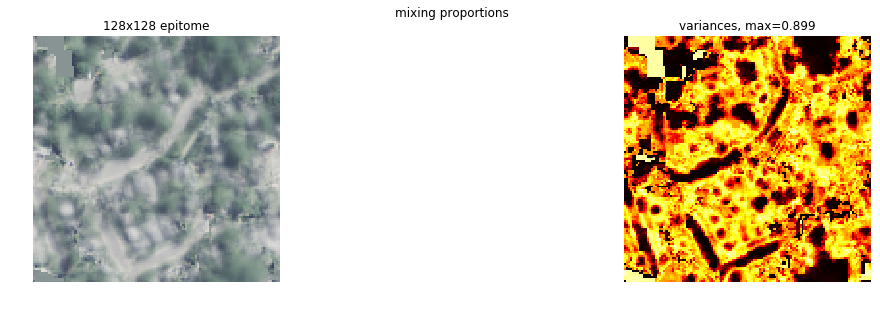

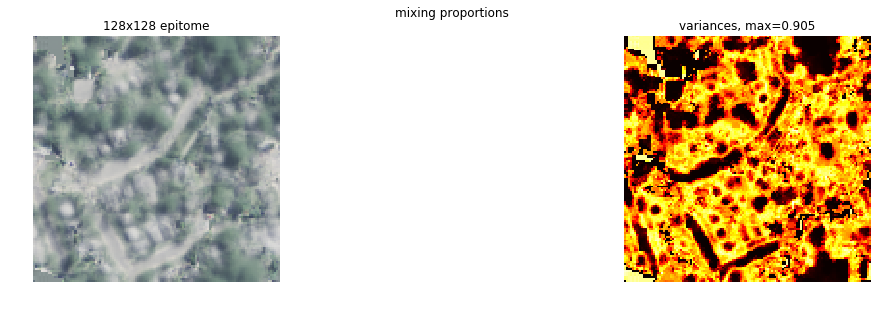

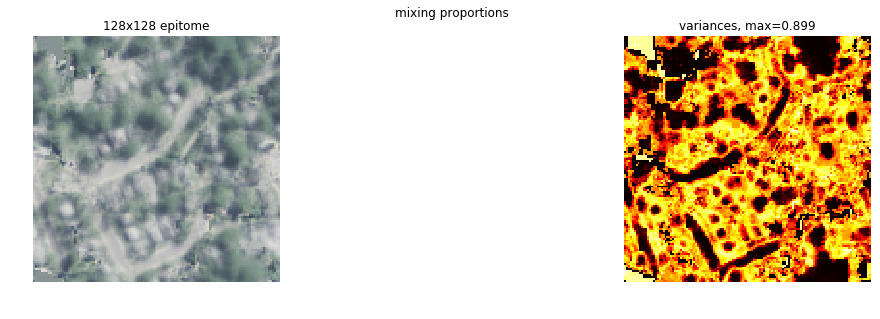

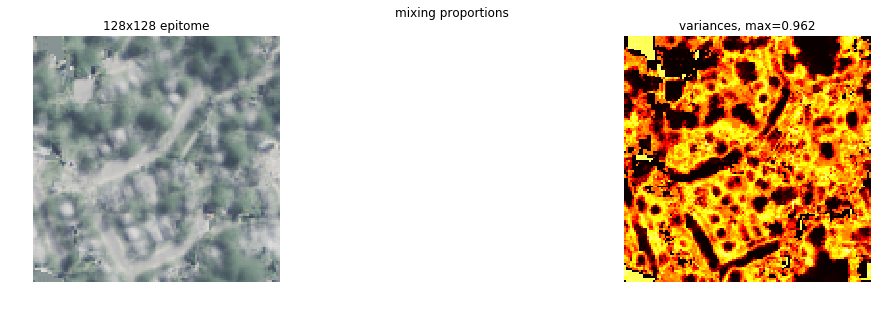

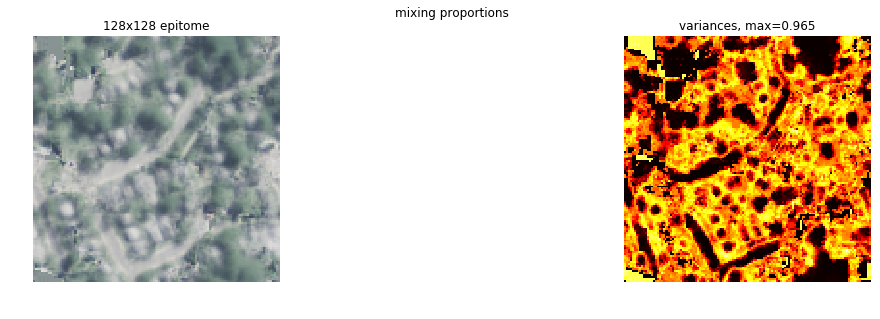

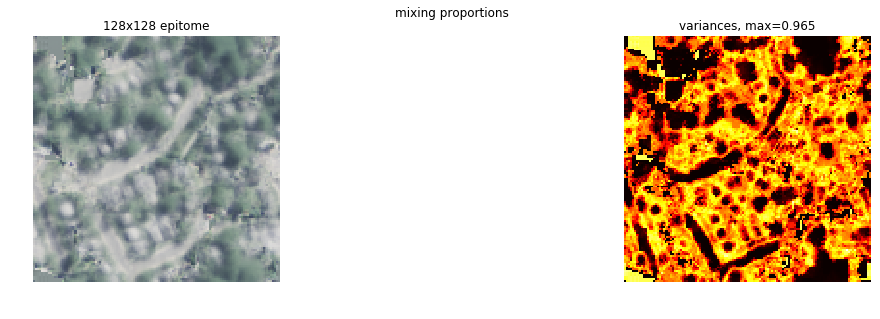

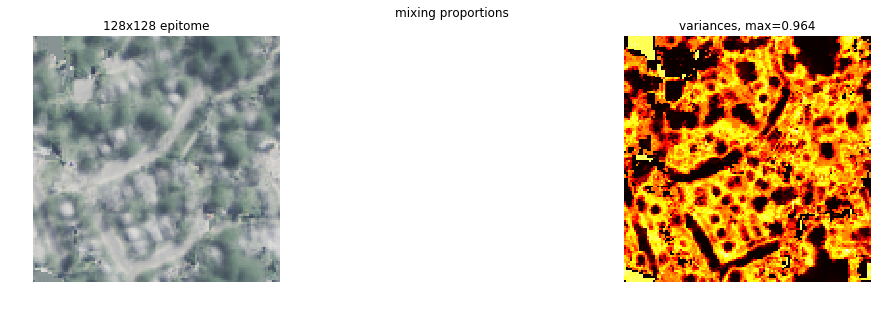

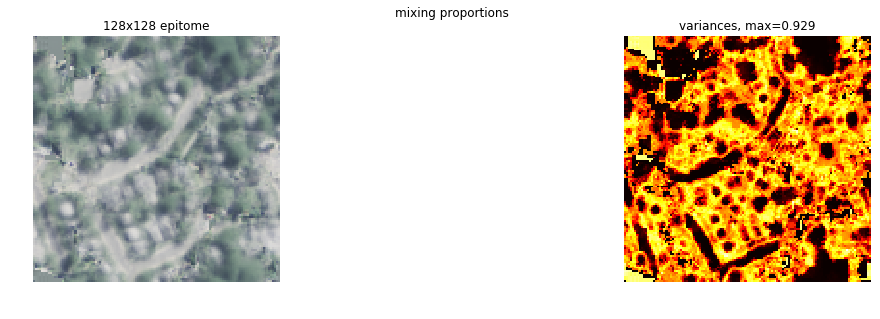

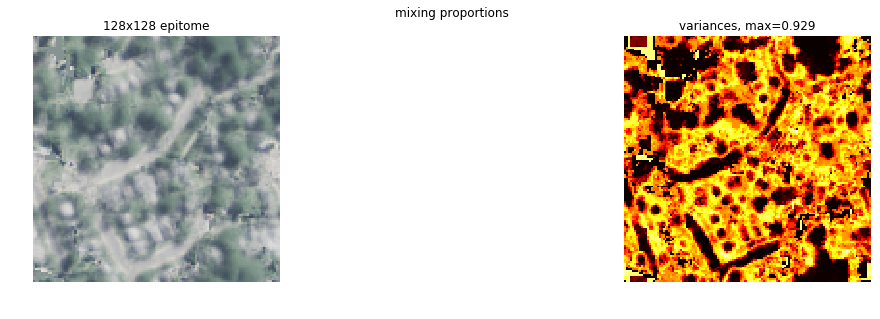

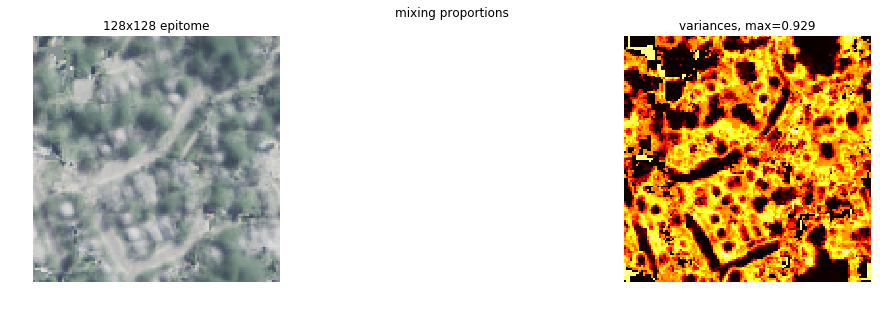

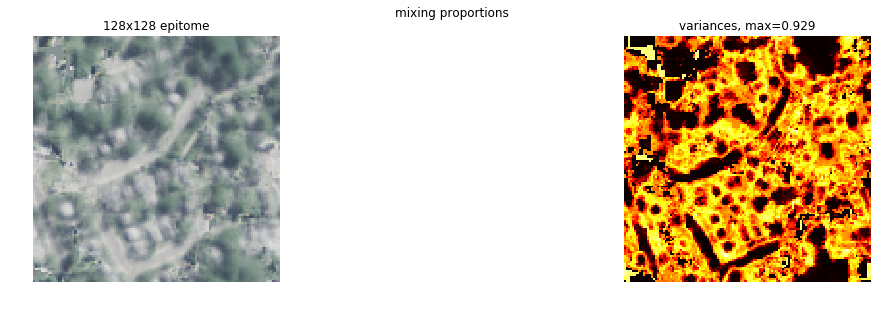

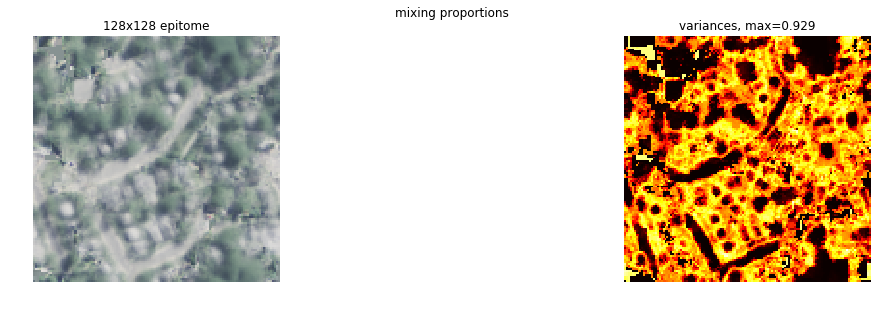

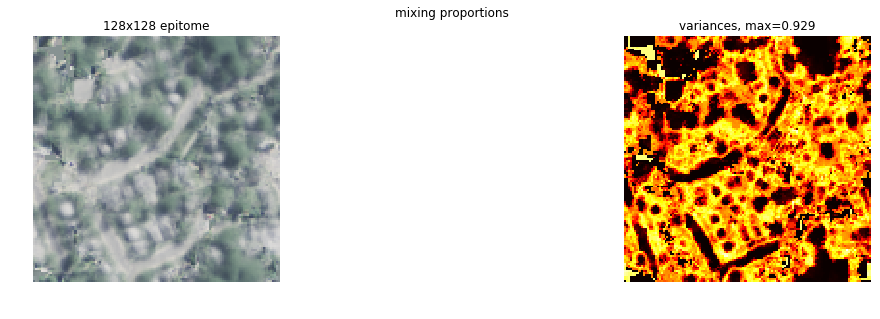

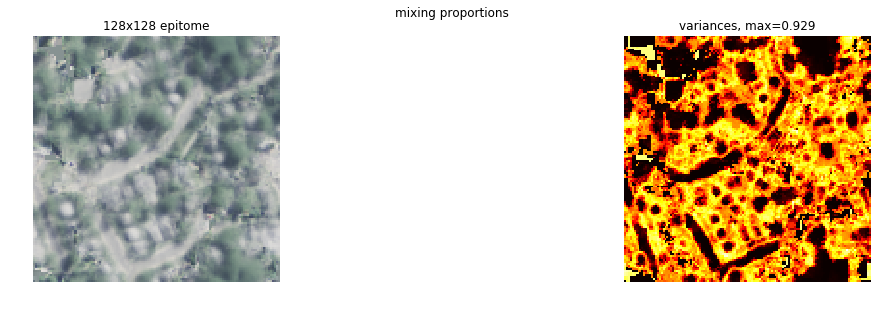

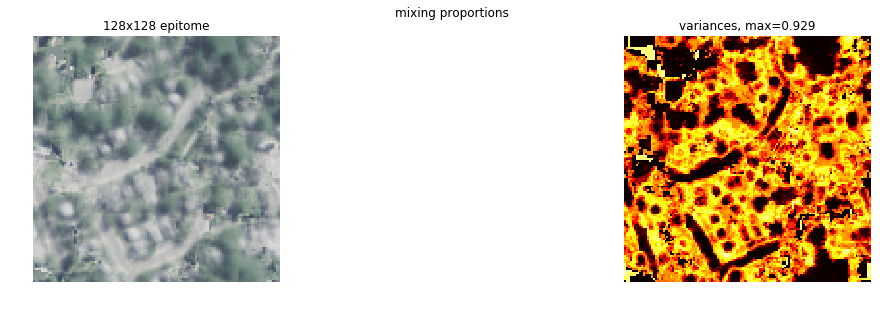

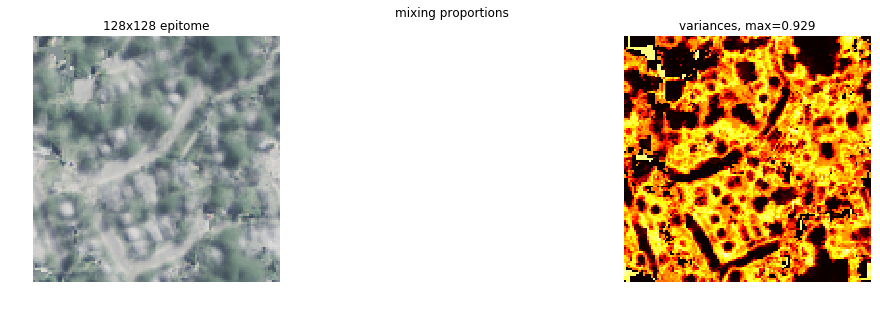

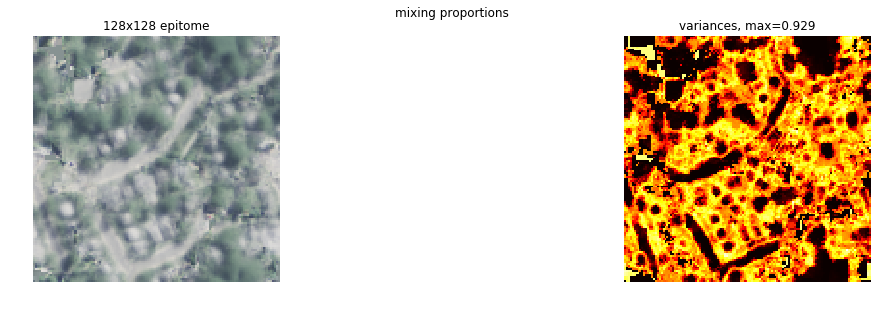

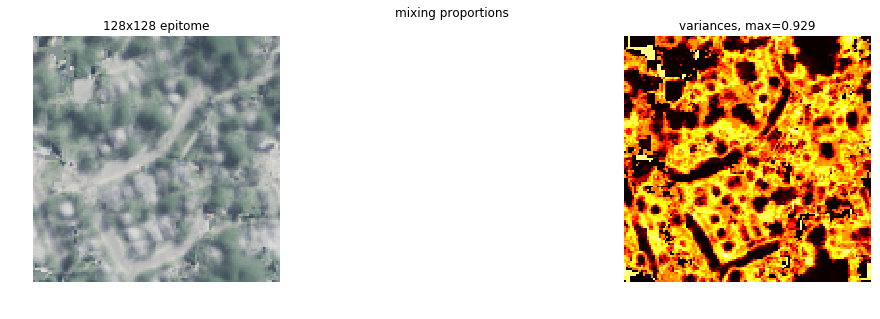

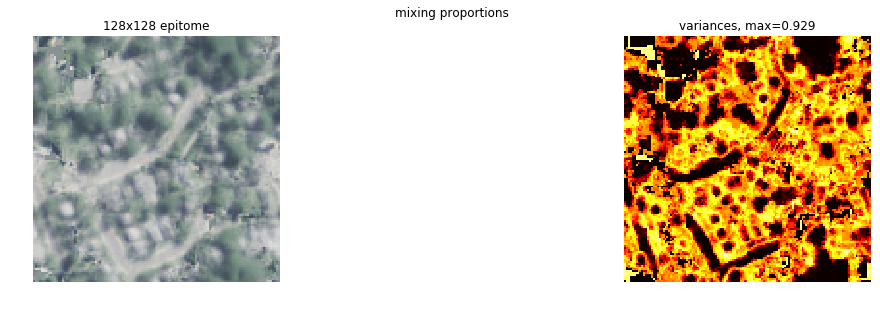

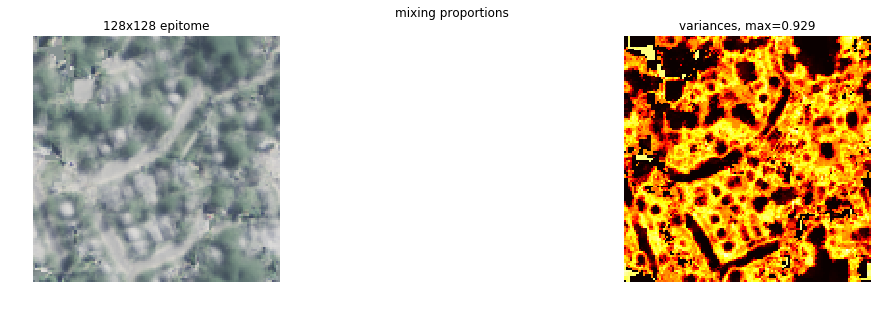

         19002150 function calls (18805310 primitive calls) in 258.718 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  258.718  258.718 {built-in method builtins.exec}
        1    0.001    0.001  258.718  258.718 <string>:1(<module>)
        1  111.045  111.045  258.717  258.717 <ipython-input-6-e35ec989e850>:20(epitome)
   164200   18.936    0.000   41.637    0.000 <ipython-input-6-e35ec989e850>:3(cum_sum)
   328280    1.412    0.000   37.002    0.000 functional.py:2112(pad)
   328280    3.634    0.000   35.363    0.000 {built-in method apply}
   328280    7.942    0.000   31.730    0.000 padding.py:12(forward)
   328280   23.799    0.000   23.799    0.000 {built-in method conv2d}
   164080   16.039    0.000   16.039    0.000 {built-in method max}
       60    0.000    0.000   13.937    0.232 pyplot.py:236(show)
       60    0.002    0.000   13.937    0.232 backend_inline.py:18(show)
       

      360    0.001    0.000    0.011    0.000 transforms.py:1812(transform_path_affine)
     8580    0.007    0.000    0.011    0.000 font_manager.py:817(set_style)
     8760    0.006    0.000    0.011    0.000 font_manager.py:1102(get_default_size)
     8940    0.006    0.000    0.011    0.000 text.py:240(set_rotation_mode)
    41840    0.011    0.000    0.011    0.000 transforms.py:1957(get_matrix)
     2880    0.003    0.000    0.011    0.000 axis.py:1599(set_minor_locator)
      300    0.001    0.000    0.010    0.000 _base.py:2130(_process_unit_info)
      723    0.001    0.000    0.010    0.000 {method 'sum' of 'numpy.ndarray' objects}
    61120    0.010    0.000    0.010    0.000 {method 'values' of 'dict' objects}
     2800    0.007    0.000    0.010    0.000 __init__.py:2026(is_math_text)
      720    0.001    0.000    0.010    0.000 artist.py:828(set_visible)
      302    0.009    0.000    0.010    0.000 iostream.py:195(schedule)
      540    0.001    0.000    0.010    0.000 

      120    0.000    0.000    0.000    0.000 image.py:249(get_size)
      660    0.000    0.000    0.000    0.000 formatters.py:359(_check_return)
      240    0.000    0.000    0.000    0.000 core.py:3175(_scalar_heuristic)
      180    0.000    0.000    0.000    0.000 {method 'copy' of '_hashlib.HASH' objects}
      120    0.000    0.000    0.000    0.000 _base.py:1826(_sci)
       22    0.000    0.000    0.000    0.000 {method 'fill' of 'numpy.ndarray' objects}
     1500    0.000    0.000    0.000    0.000 path.py:241(simplify_threshold)
       60    0.000    0.000    0.000    0.000 {method 'replace' of 'datetime.datetime' objects}
      780    0.000    0.000    0.000    0.000 figure.py:88(<listcomp>)
      240    0.000    0.000    0.000    0.000 py3compat.py:188(iteritems)
      540    0.000    0.000    0.000    0.000 pretty.py:100(_safe_getattr)
       68    0.000    0.000    0.000    0.000 functional.py:1944(_output_size)
      360    0.000    0.000    0.000    0.000 transforms.

CPU times: user 3min 54s, sys: 42 s, total: 4min 36s
Wall time: 4min 19s


In [8]:
%%time
#no longer accepts initializations of e or ev
cProfile.run('e,ev,p,etr=epitome(trIMtorch,9,256,25000,20,[.125,.25,.5])',sort='cumtime')
#cProfile.run('e,ev,p,etr=epitome(trIMtorch,8,128,4000,20,[.5])',sort='cumtime')
torch.cuda.empty_cache()

In [38]:
#Replaces the epitome (e,ev) of an image by another epitome image (emod)
#keeping the mapping intact. The routine can be used to edit images or to
#preprocess by coloring the image accoring to the image (see the segmentation
#part of the web page for more info). K specifies the patch size to use in 
#mapping inference and SPC defines the patch spacing.

def reconstruct(x,K,e,ev,emod,SPC):
    _,NoCh1,Ny,Nx = x.shape
    NoCh2 = emod.shape[0]
    #print(NoCh1,NoCh2)
    if NoCh1 == 1:
        x = torch.stack((x,x,x),dim=0)
        print(x.shape)
    NoCh1,N,Ny = e.shape
    SY = x.shape[2]
    SX = x.shape[3]
    ewrap = torch.zeros((1,NoCh1,N+K-1,N+K-1)).to(device)
    evwrap = torch.zeros((1,NoCh1,N+K-1,N+K-1)).to(device)
    MINP = 1e-8
    ewrap[0,:,:N,:N] = e
    ewrap[:,:,N:,:] = ewrap[:,:,:K-1,:]
    ewrap[:,:,:,N:] = ewrap[:,:,:,:K-1]
    evwrap[0,:,:N,:N] = ev
    evwrap[:,:,N:,:] = evwrap[:,:,:K-1,:]
    evwrap[:,:,:,N:] = evwrap[:,:,:,:K-1]
    evwrapi = 1./evwrap
    tmp3 = torch.squeeze(cum_sum(ewrap**2*evwrapi,K))
    tmp4 = torch.squeeze(cum_sum(torch.log(evwrap),K))
    emodwrap = torch.zeros((NoCh2,N+K-1,N+K-1)).to(device)
    emodwrap[:,:N,:N] = emod
    emodwrap[:,N:,:] = emodwrap[:,:K-1,:]
    emodwrap[:,:,N:] = emodwrap[:,:,:K-1]
    z = torch.zeros((NoCh2,SY,SX)).to(device)
    cnt = torch.zeros((SY,SX)).to(device)
    ixt = 0
    iyt = 0
    #for each patch of the input, find the distribution over the epitome positions,
    #and reconstruct the patch in the input image, using the modified epitome.
    for iy in range(0,SY-K+1,SPC):
        print('y index = '+str(iy))
        for ix in range(0,SX-K+1,SPC):
            #watch for indexing errors
            yct = torch.flip(x[:,:,iy:iy+K,ix:ix+K],[2,3])
            tmp1 = torch.squeeze(F.conv2d(evwrapi,yct**2))
            tmp2 = torch.squeeze(F.conv2d(ewrap*evwrap,yct))
            lP = torch.sum(-.5*(tmp4+tmp1-2*tmp2+tmp3),dim=0)
            P = torch.exp(lP-torch.max(lP))+MINP
            P /= torch.sum(P)
            argmax = torch.argmax(P)
            mxpi = argmax//P.shape[0]
            mxpj = argmax - mxpi*P.shape[0]
            #watch for indexing errors
            z[:,iy:iy+K,ix:ix+K] += emodwrap[:,mxpi:mxpi+K,mxpj:mxpj+K]
            cnt[iy:iy+K,ix:ix+K] += 1
            ixt = ix
            iyt = iy
    z = z[:,:iyt+K,:ixt+K]
    cnt = cnt[:iyt+K,:ixt+K]
    z /= cnt
    return z

In [39]:
%%time
cProfile.run('z2=reconstruct(tsIMtorch[:,:4,:cut,:cut],17,e[0,:4,:cut,:cut],ev[0,:4,:cut,:cut],e[0,4:,:cut,:cut],3)')
torch.cuda.empty_cache()

y index = 0
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
cuda:1
c

KeyboardInterrupt: 

In [40]:
zcpu = z2.cpu().numpy()
zcpu.shape

(6, 1022, 1022)

In [26]:
#np.savez_compressed('reconstruction2',a=zcpu)

In [36]:
zmax = np.argmax(np.reshape(zcpu,(6,-1)),axis=0)
zre = np.reshape(zmax,(zcpu.shape[1],-1))
zre.shape

(1022, 1022)

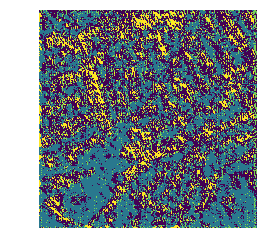

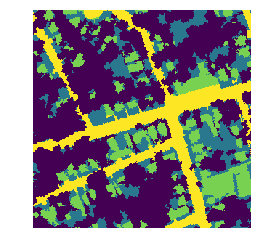

In [37]:
plt.figure()
plt.imshow(zre)
plt.axis('off')
plt.show()
plt.close()
plt.figure()
plt.imshow(lc[:300,:300])
plt.axis('off')
plt.show()
plt.close()

In [6]:
trIMtorch.shape

torch.Size([1, 10, 1024, 1024])

In [11]:
flipped = torch.flip(trIMtorch[:,:,:10,:10],[2,3])
conv2 = torch.squeeze(F.conv2d(trIMtorch,flipped))
conv2.shape

torch.Size([1015, 1015])

In [12]:
conv = torch.squeeze(F.conv_transpose2d(trIMtorch,trIMtorch[:,:,:10,:10]))

RuntimeError: Given transposed=1, weight of size [1, 10, 10, 10], expected input[1, 10, 1024, 1024] to have 1 channels, but got 10 channels instead

In [24]:
tt = torch.from_numpy(np.reshape(np.arange(27),(3,3,3))).float()
ss = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])

In [27]:
print(tt[0])
print(ss)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])


In [26]:
tt/ss

tensor([[[ 0.0000,  0.5000,  0.6667],
         [ 0.7500,  0.8000,  0.8333],
         [ 0.8571,  0.8750,  0.8889]],

        [[ 9.0000,  5.0000,  3.6667],
         [ 3.0000,  2.6000,  2.3333],
         [ 2.1429,  2.0000,  1.8889]],

        [[18.0000,  9.5000,  6.6667],
         [ 5.2500,  4.4000,  3.8333],
         [ 3.4286,  3.1250,  2.8889]]])